## Try out model from TempoBert
I think the `test_bert` module only works with the 'old' [tempobert](https://github.com/guyrosin/tempobert/) model, where the sentence was prepended with a token. The model [linked on github](https://github.com/guyrosin/temporal_attention/issues/1) is of type "attention_double_time". The tokenizer needs an extra argurment `time_id` which can take 2 values.


In [51]:
from bert_model import BertModel
from train_tempobert import ModelArguments
from transformers import AutoModelForMaskedLM, pipeline

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
import test_bert
import hf_utils

Load the model:

In [3]:
hf_utils.prepare_tf_classes()
model_name = 'temp_att_model_semeval_eng'
model_args = ModelArguments(model_name_or_path=model_name)
config_kwargs = {}
model, tokenizer = hf_utils.load_pretrained_model(
    model_args,
    AutoModelForMaskedLM,
    expect_times_in_model=True,
    **config_kwargs,
)

In [5]:
tokenizer

PreTrainedTokenizerFast(name_or_path='temp_att_model_semeval_eng', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

We create a pipeline, but automatically calling the pipeline doesn't work because the tokenizer encoding function needs an extra argument `time_id`, so we create a manual function.

In [6]:
fill_mask_pipeline = pipeline("fill-mask", model=model, tokenizer=tokenizer)

In [7]:
def run_pipeline(pipeline, sentences, time_id):
    if type(sentences)==str:
        encoded_inputs = pipeline.tokenizer.encode_plus(sentences, time_id=time_id, return_tensors='pt')
    else:
        encoded_inputs = pipeline.tokenizer.batch_encode_plus(sentences, batch_time_id=time_id*len(sentences), return_tensors='pt', padding=True)
    output = pipeline.forward(encoded_inputs)
    result = pipeline.postprocess(output)
    return result

In [8]:
sentence = "It is a national characteristic of the Englishman that he regards no athletic , open-air sport as worthy of the name unless it involves a good deal of danger and a [MASK] amount of physical misery ."
run_pipeline(fill_mask_pipeline, sentence, "1")

[{'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a. amount of physical misery.',
  'score': 0.05581890419125557,
  'token': 1012,
  'token_str': '.'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a code amount of physical misery.',
  'score': 0.02099780924618244,
  'token': 3642,
  'token_str': 'code'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a one amount of physical misery.',
  'score': 0.016581013798713684,
  'token': 2028,
  'token_str': 'one'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it invo

In [9]:
run_pipeline(fill_mask_pipeline, sentence, "2")

[{'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a. amount of physical misery.',
  'score': 0.06356566399335861,
  'token': 1012,
  'token_str': '.'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a code amount of physical misery.',
  'score': 0.020715968683362007,
  'token': 3642,
  'token_str': 'code'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it involves a good deal of danger and a one amount of physical misery.',
  'score': 0.020477255806326866,
  'token': 2028,
  'token_str': 'one'},
 {'sequence': 'it is a national characteristic of the englishman that he regards no athletic, open - air sport as worthy of the name unless it inv

## For list of sentences


In [4]:
import pandas as pd

datapath = '../sentences_out'

term = 'fair'
df_sentences = pd.read_csv(os.path.join(datapath, term+'.csv'))
df_sentences['sentence_lc'] = df_sentences['sentence'].str.lower()

<AxesSubplot:>

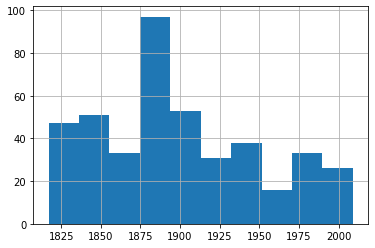

In [5]:
df_sentences['year'].hist()

In [5]:
df_sentences['time_id'] = ['1' if year <= 1860 else None for year in df_sentences['year']]
df_sentences.loc[df_sentences['year'] >= 1960, 'time_id'] = '2'
df_sentences['time_id'].value_counts(dropna=False)

NaN    254
1      102
2       69
Name: time_id, dtype: int64

In [6]:
sentences_1 = df_sentences[df_sentences.time_id=='1']['sentence']
sentences_2 = df_sentences[df_sentences.time_id=='2']['sentence']

Note that the term may appear multiple times in one sentence. `model.embed_word` retrieves all embeddings of all appearences, so the total number of embeddings may be larger than the number of sentences. We want to take the average per sentence.

In [7]:
from semantic_change_detection import get_embedding

tester = test_bert.Tester(model_name, preload=True)
model = tester.bert_models[0]


In [41]:
embeddings = []
for i, row in df_sentences.iterrows():
    if row['time_id'] is not None:
        emb = get_embedding(
            model,
            [row['sentence_lc']],
            term,
            time=str(row['time_id'])).numpy()
    else:
        emb = None
    embeddings.append(emb)

In [42]:
df_sentences['embedding'] = embeddings

In [44]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2)


In [49]:
df_embeddings = df_sentences[~df_sentences['embedding'].isna()]
X = np.array([e for e in df_embeddings['embedding']])
X.shape

(171, 768)

In [50]:
X_pca = pca.fit_transform(X)
df_embeddings['pca1'] = X_pca[:,0]
df_embeddings['pca2'] = X_pca[:,1]

C:\Users\DafnevanKuppevelt\AppData\Local\Temp\ipykernel_15688\806366345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embeddings['pca1'] = X_pca[:,0]
C:\Users\DafnevanKuppevelt\AppData\Local\Temp\ipykernel_15688\806366345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embeddings['pca2'] = X_pca[:,1]


Text(0.5, 1.0, 'PCA colored per time_id')

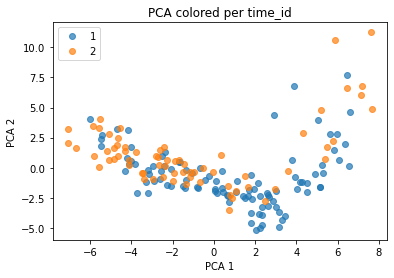

In [52]:
for key, group in df_embeddings.groupby(['time_id']):
    plt.plot(group.pca1, group.pca2, 'o', alpha=0.7, label=key)
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("PCA colored per time_id")

In [53]:
df_embeddings.to_csv('../sentences_out/{}_embedded_temporal_attention.csv'.format(term), index=False)